## TASK 1: Develop a machine learning model

In [1]:
# Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# Make plots look nicer
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 120

df = pd.read_csv("Earthquakes.csv", low_memory=False)  

df.head()

,id,mag,place,time,updated,tz,url,detail,felt,cdi,...,nst,dmin,rms,gap,magType,type_property,title,longitude,latitude,depth
0,cent19000105190000000,7.0,"Southern Sumatra, Indonesia",1900-01-06 3:00,16:56.0,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,NaN,NaN,NaN,NaN,ms,earthquake,"M 7.0 - Southern Sumatra, Indonesia",102.0,-3.0,NaN
1,cent19000111090700000,7.0,Bismarck Sea,1900-01-11 17:07,55:15.6,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,NaN,NaN,NaN,NaN,ms,earthquake,M 7.0 - Bismarck Sea,148.0,-5.0,NaN
2,official19000112171500000,NaN,"Yakutat Bay, Alaska Earthquakes (Aftershock)",1900-01-13 1:00,42:08.8,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,earthquake,"M ? - Yakutat Bay, Alaska Earthquakes (Aftersh...",-140.0,60.0,NaN
3,cent19000120063300000,7.3,"Jalisco, Mexico",1900-01-20 14:33,36:34.4,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,NaN,NaN,NaN,NaN,mw,earthquake,"M 7.3 - Jalisco, Mexico",-105.0,20.0,NaN
4,official19000128041500000,NaN,"Yakutat Bay, Alaska Earthquakes (Aftershock)",1900-01-28 12:00,48:05.8,NaN,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,earthquake,"M ? - Yakutat Bay, Alaska Earthquakes (Aftersh...",-140.0,60.0,NaN


In [2]:
# Clean missing rows
df = df[df["magType"].notna()]
df = df[df["mag"].notna()]
df = df[df["longitude"].notna()]
df = df[df["latitude"].notna()]

# Fix depth
df["depth"] = df["depth"].fillna(df["depth"].median())

# Remove magTypes that appear only once
class_counts = df["magType"].value_counts()
rare_classes = class_counts[class_counts < 2].index
df = df[~df["magType"].isin(rare_classes)]

# Select features and target
feature_columns = ["mag", "longitude", "latitude", "depth"]
target_column = "magType"

X = df[feature_columns].values
y = df[target_column].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

len(X_train), len(X_test)

(654088, 280324)

In [3]:
# MinMax scaling
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train)
X_test_minmax = minmax_scaler.transform(X_test)

# kNN model with k = 1
knn_k1_minmax = KNeighborsClassifier(n_neighbors=1)
knn_k1_minmax.fit(X_train_minmax, y_train)

train_acc_k1 = knn_k1_minmax.score(X_train_minmax, y_train)
test_acc_k1 = knn_k1_minmax.score(X_test_minmax, y_test)

print("Task 1 - kNN with k=1 and MinMaxScaler")
print(f"Training accuracy: {train_acc_k1:.3f}")
print(f"Test accuracy:     {test_acc_k1:.3f}")

Task 1 - kNN with k=1 and MinMaxScaler
Training accuracy: 1.000
Test accuracy:     0.887


## TASK 2: Doing some analysis to find the best value of k

### 2a) Accuracy vs k (MinMaxScaler)

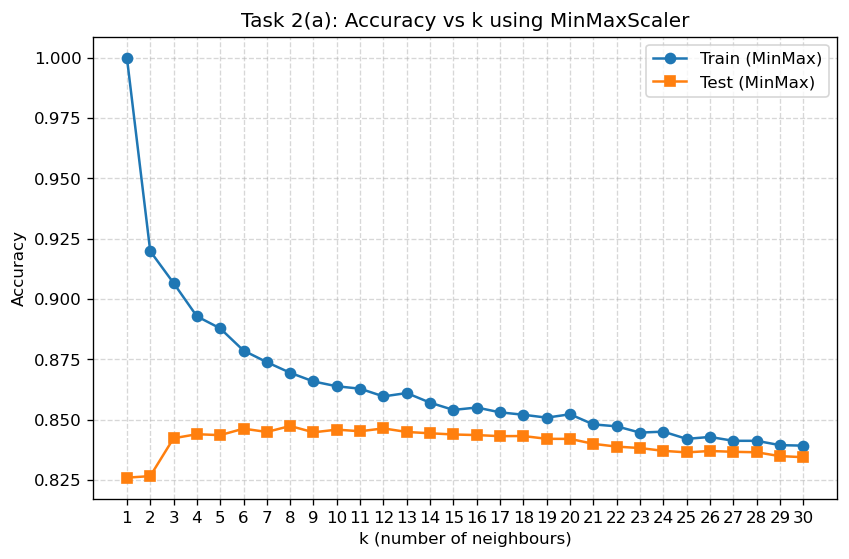

In [4]:
k_values = range(1, 31)   # range of k-values to test

# use smaller subset of training data for faster loading
X_train_mm_small = X_train_minmax[:5000]   # first 5000 rows
y_train_small = y_train[:5000]

# lists to store accuracies 
train_accuracies_minmax = []
test_accuracies_minmax = []

for k in k_values:
    # create and train a kNN model with current k
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_mm_small, y_train_small)  # use the smaller set

    # record accuracy on training subset and full test set
    train_accuracies_minmax.append(model.score(X_train_mm_small, y_train_small))
    test_accuracies_minmax.append(model.score(X_test_minmax, y_test))

# plot
plt.figure()
plt.plot(k_values, train_accuracies_minmax, marker="o", label="Train (MinMax)")
plt.plot(k_values, test_accuracies_minmax, marker="s", label="Test (MinMax)")
plt.xlabel("k (number of neighbours)")
plt.ylabel("Accuracy")
plt.title("Task 2(a): Accuracy vs k using MinMaxScaler")
plt.xticks(k_values)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

### 2b) Accuracy vs. k (StandardScaler)

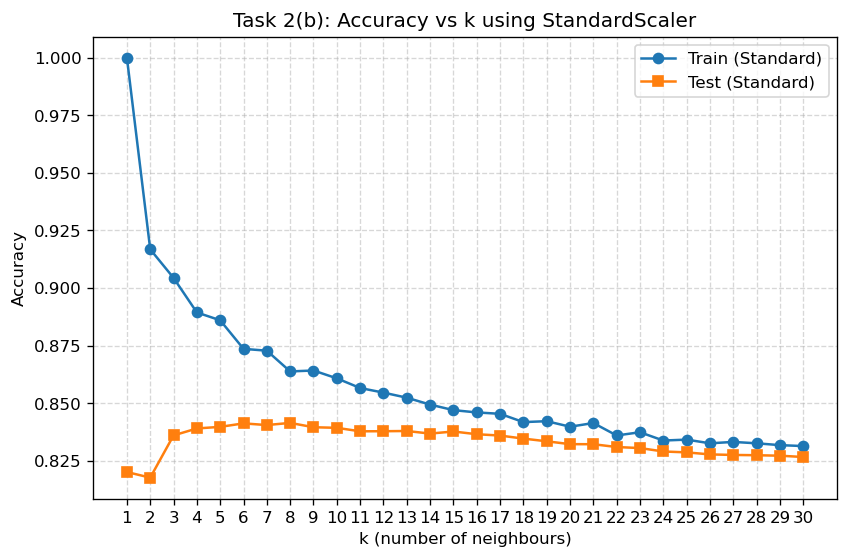

In [5]:
k_values = range(1, 31)   # k = 1 to 30

# scaling on full training and test sets
standard_scaler = StandardScaler()
X_train_std = standard_scaler.fit_transform(X_train)
X_test_std  = standard_scaler.transform(X_test)

# use smaller subset
X_train_std_small = X_train_std[:5000]   # first 5000 rows
y_train_std_small = y_train[:5000]

# lists to store
train_accuracies_std = []
test_accuracies_std  = []

for k in k_values:
   
    # create and train a kNN model with current k
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train_std_small, y_train_std_small)  # smaller training set

    # record accuracy on training subset and full test set
    train_accuracies_std.append(model.score(X_train_std_small, y_train_std_small))
    test_accuracies_std.append(model.score(X_test_std,  y_test))  # test on full set

# plot
plt.figure()
plt.plot(k_values, train_accuracies_std, marker="o", label="Train (Standard)")
plt.plot(k_values, test_accuracies_std,  marker="s", label="Test (Standard)")
plt.xlabel("k (number of neighbours)")
plt.ylabel("Accuracy")
plt.title("Task 2(b): Accuracy vs k using StandardScaler")
plt.xticks(k_values)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Task 3

## TASK 3(a): Choose best k and best scaler, train final model

In [6]:

# Best k for MinMax (based on subset test accuracy)
best_index_minmax = int(np.argmax(test_accuracies_minmax))
best_k_minmax = list(k_values)[best_index_minmax]
best_test_acc_minmax = test_accuracies_minmax[best_index_minmax]
best_train_acc_minmax = train_accuracies_minmax[best_index_minmax]

# Best k for Standard (based on subset test accuracy)
best_index_std = int(np.argmax(test_accuracies_std))
best_k_std = list(k_values)[best_index_std]
best_test_acc_std = test_accuracies_std[best_index_std]
best_train_acc_std = train_accuracies_std[best_index_std]

# Print results for both scalers
print("Best with MinMaxScaler:")
print(f"  k = {best_k_minmax}")
print(f"  Train accuracy (subset) = {best_train_acc_minmax:.3f}")
print(f"  Test accuracy  (subset) = {best_test_acc_minmax:.3f}\n")

print("Best with StandardScaler:")
print(f"  k = {best_k_std}")
print(f"  Train accuracy (subset) = {best_train_acc_std:.3f}")
print(f"  Test accuracy  (subset) = {best_test_acc_std:.3f}\n")

# Choose final scaler based on higher subset test accuracy
if best_test_acc_minmax >= best_test_acc_std:
    final_scaler_name = "MinMaxScaler"
    final_k = best_k_minmax
    final_scaler = MinMaxScaler().fit(X_train)    # fit on full train data
    X_train_final = final_scaler.transform(X_train)
    X_test_final  = final_scaler.transform(X_test)
else:
    final_scaler_name = "StandardScaler"
    final_k = best_k_std
    final_scaler = StandardScaler().fit(X_train)  # fit on full train data
    X_train_final = final_scaler.transform(X_train)
    X_test_final  = final_scaler.transform(X_test)

# train the final kNN model on fully scaled training data 
final_model = KNeighborsClassifier(n_neighbors=final_k)
final_model.fit(X_train_final, y_train)

# evaluate final model
final_train_acc = final_model.score(X_train_final, y_train)
final_test_acc  = final_model.score(X_test_final,  y_test)

# print final chosen model results
print("Final model chosen:")
print(f"  Scaler used      = {final_scaler_name}")
print(f"  k                = {final_k}")
print(f"  Train accuracy   = {final_train_acc:.3f}")
print(f"  Test accuracy    = {final_test_acc:.3f}")

Best with MinMaxScaler:
  k = 8
  Train accuracy (subset) = 0.869
  Test accuracy  (subset) = 0.847

Best with StandardScaler:
  k = 8
  Train accuracy (subset) = 0.864
  Test accuracy  (subset) = 0.841

Final model chosen:
  Scaler used      = MinMaxScaler
  k                = 8
  Train accuracy   = 0.919
  Test accuracy    = 0.903


## TASK 3(b): Confusion matrix for final model

In [7]:
# predict labels for the test set using the final model
y_test_pred = final_model.predict(X_test_final)

# compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

print("Confusion matrix (rows = true magType, columns = predicted magType):")
print(cm)

# To know label order:
labels = np.unique(np.concatenate([y_test, y_test_pred]))
print("\nOrder of labels in confusion matrix:")
print(labels)

Confusion matrix (rows = true magType, columns = predicted magType):
[[    14      1      0      0      0      4      1      0      0      3
       3      0      0      0      1      0      0      0      0      0
       0      0]
 [     2      0      0      0      0      4      3      2      0     13
       0      0      0      0      1      0      0      0      0      0
       0      0]
 [     0      0     86      0      0     38      0     51      0     33
       0      0      0      0     67      0      0      0      0      0
       0      0]
 [     0      0      0      0      0      2      0      0      0      0
       0      0      0      0      0      0      0      0      7      0
       0      0]
 [     0      0      0      0     58      0      0      0      0    554
       0      1      0      0      2      0      0      0      0      0
       0      0]
 [     5      1     18      0      0  29518      1     18      0    249
       1      4      0      0    516      0     33    

# TASK 4

In [8]:
# [mag, longitude, latitude, depth]
new_instance_values = [[5.6, -120.5, 34.2, 10.0]]

# create a dataframe for clear display 
new_instance_df = pd.DataFrame(new_instance_values, columns=feature_columns)
print("New instance attributes:")
display(new_instance_df)

# scale the new instance using the same scaler as final model
new_instance_scaled = final_scaler.transform(new_instance_df.values)

# predict magType label
predicted_class = final_model.predict(new_instance_scaled)[0]
print("\nPredicted magType for this new instance:", predicted_class)

New instance attributes:


,mag,longitude,latitude,depth
0,5.6,-120.5,34.2,10.0



Predicted magType for this new instance: ml
